# Week 10: Convolutional Neural Networks

<hr style="border:2px solid gray">

# Outline <a id='outline'></a>

1. [Section One: Introduction to convolutional neural networks](#section-1)
1. [Section Two: Convolutional neural networks in PyTorch](#section-2)
1. [Section Three: A convolutional neural network example with Fashion MNIST](#section-3)
1. [Section Four: The CIFAR-10 dataset](#section-4)
1. [Section Five: Exercises](#section-5)

<hr style="border:2px solid gray">

# Section One: Introduction to convolutional neural networks [^](#outline) <a id='section-1'></a>

So far, we have tackled problems we can solve with linear layers and nonlinear activation functions. Let us consider an image classification problem, for example using the MNIST dataset (which is a dataset of 28 by 28 grayscale images). 

<div style="background-color:#C2F5DD">

### Example
    
Consider a binary classification problem such that we have a single output, we flatten our 28 by 28 image input into a 784 length input vector, and we construct a fully connected network with a single hidden layer of 512 neurons. 
    
How many parameters are in this network? Discuss with people near you.    

Your answer here

<div style="background-color:#C2F5DD">

End of example

If we now consider the same network construction for a full HD image that is 1920 by 1080, we find we have over a billion parameters for this network. If we consider a colour image,  Clearly, it will very quickly become unfeasible to train a standard neural network for image classification tasks. Because of how many parameters we have, we are likely to overfit when we train such a network. How can we solve this problem? 

When we look at an image, a given pixel is likely to share structure with other pixels near it in the image. We can use this to inform how we structure our model; we want to somehow use this shared **local** structure to develop a good classifier. 

While our standard neural networks are made of linear layers and activation functions, convolutional neural networks add a new type of layer: convolutional layers. 


## Convolutional layers

You will be familiar with convolutions from previous courses on Fourier transforms, but we will briefly review the fundamental concepts before we discuss how they are applied in machine learning.

<div style="background-color:#FFCCCB">

A convolution between two functions produces a third function that expresses how the shape of one of the functions is modified by the other. The convolution of two functions $f$ and $g$ can be written as 

\begin{equation*}
(f * g)(t) = \int_{-\infty}^\infty f(t - \tau) g(\tau) d\tau,
\end{equation*}
where $\tau$ is a dummy variable introduced for the integration. We can see this as "sliding" the function $f(t - \tau)$ over the function $g(t)$ as we vary $\tau$ in the integration. 

If instead our functions $f$ and $g$ are functions of discrete variables, we can write this expression as a sum instead of an integral:

\begin{equation*}
(f * g)(t) = \sum_{\tau = -\infty}^\infty f(t - \tau) g(\tau)
\end{equation*}

When we apply convolutions in convolutional neural networks, we refer to the function $g(\tau)$ as the input, and the function $f(t - \tau)$ as the **kernel**. The output function $(f * g)(t)$ can be referred to as the **feature map**. Typically, our input is some multidimensional array of data (for example, a colour image with 3 colour channels corresponding to red, green and blue) and the kernel is some multidimensional array of parameters which are learned in the training process. 

Because our inputs are in general finite numerical arrays, we can instead of taking the sum to $-\infty$ and $\infty$ we can instead sum over a finite number of array elements. We also often use convolutions over more than one axis at a time. For example, for a two-dimensional image $I$ as the input and a two-dimensional kernel $K$, we can write the convolution as

\begin{equation*}
S(i, j) = (I * K)(i, j) = \sum_m \sum_n I(m, n) K(i - m, j - n)
\end{equation*}

To put it simply when we apply a kernel of size $N \times M$:

* We take all of the pixels in an $N \times M$ grid around a point in the image and performs a weighted sum, where the kernel contains the weights we use
<br>

* Then, move the kernel one pixel over and take another weighted sum (with the same weights) of the new set of pixels. 
<br>

* You repeat this process for the whole image 

The resulting array is called the feature map and effectively encodes relationships between pixels that are close together, depending on the parameters in the kernel. 

The figure below is an animation showing how we build a feature map from a $4 \times 4$ input and a $2 \times 3$ kernel:

<img src='Week10_plots/conv.gif' align='center' width = 600>

We can also illustrate a convolutional neural network with a schematic of layers with different volumes. Each layer has a height and a width, based on the height and width of an image. We also can have multiple channels in a layer (or our input). In the input this often corresponds to RGB channels in an image, but in our feature maps this can correspond to specific features extracted. We can use multiple kernels in a given layer to produce more channels in our feature map.

<img src='Week10_plots/cnn_depth_schematic.png' width=600>

*Schematic illustrating the action of convolutional layers. Each convolutional layer decreases the height and width but increases the number of channels, and the feature map is converted to an output with a single fully connected linear layer at the end.*

## Features of convolutional layers



Convolutional layers learn from data by changing the parameters kept in the kernel. This results in a few key features for this type of network:

1. Translational invariance
1. Re-use of parameters

We will discuss each of these in turn.



### Translational invariance

If we train a standard neural network on an image dataset, the neurons in individual layers learn to respond to specific pixels in the image. For example, consider an neural network to identify where a dog is in an image. If we just train it with pictures of dogs in the lower right of the image, as soon as we present a data point with the dog in e.g. the upper left, the model will perform poorly.

In contrast, because for a convolutional neural network the weights are all stored in the kernel, you do not learn on specific pixels and instead extract relationships between adjacent pixels. This means you can pick up individual patterns regardless of where they are in the input, meaning your network response has translational invariance. 

For example, say we have a kernel that is good at locating a dog in an image. Because all the weights are in the kernel, if we shift the location of a dog in an image all we do is shift the corresponding output by the same amount. We will be equally good at detecting the dog regardless of where it is in the image. 

### Re-use of parameters

Consider a $m \times n$ linear layer. All $m$ input values are connected to all $n$ output values, resulting in an array of weights you have to learn that is $m \times n$ in size. 

In contrast, for a convolutional network, the weights array we learn in a given layer is just the size of the kernel; e.g. for a kernel of shape $i \times j$, even if we have $m \gt i,\, j$ inputs, we only have to learn $i \times j$ parameters for that kernel. This greatly reduces the number of  weights we have to learn, to get the same sized input/output. We *only* have to learn the parameters in the kernel.



## Controlling the size of CNNs

While up to this point we have just discussed how CNNs are more effective that traditional neural networks for computer vision, we do need to be aware of the size of our CNNs. After we apply a given kernel, depending on the size of the kernel and the size of the input, we can get an output of the same size or smaller than our input. We can also increase the size relative to the input, by using more than one kernel. 

Typically, if there are more specific features we want to try to extract, we will use more kernels. For example, there are two different kernels for extracting vertical and horizontal edges from an image we saw earlier called the [Sobel operators](https://en.wikipedia.org/wiki/Sobel_operator). However, the more kernels we use, the more output neurons we end up with after our convolutional layer. 

If we are using multiple kernels every layer, we can quickly end up with much deeper layers and many more neurons than we started with, but when we come to make our final prediction we need to reduce our size down to what our output needs to be, e.g. a single number of we are predicting a single class or a single regression value. There are three main ways we can do this:

1. Have a linear, fully-connected layer at the end of our network
<br>

1. Increase the **stride**
<br>

1. Use **pooling**

The first of these results in many parameters that need to be trained, exactly what we wanted to avoid! So in general we won't do this. Instead, we make use of stride and pooling.

### Stride

The stride of a convolutional layer refers to how many pixels we move our kernel across our input when we pass through a convolutional layer. If we increase the stride, we move by more pixels between applications of the convolutional kernel; e.g. if we have a stride of N, we will do one convolution, then move our kernel by N pixels before we do another convolution. This is illustrated in the animation below.

<img src='Week10_plots/stride.gif' width=1000>

*Illustration of the effect of setting stride > 1 for a convolution. Whereas on the left we have a stride of 1 and produce an output that is 5 x 5 from the 6 x 6 input, on the right with a stride of 2 we instead produce a 3 x 3 output. We can therefore use stride to reduce the size of the output from our layer. $X_i$ denotes the $i$th input, $w_j$ denotes the $j$th weight in the kernel, and $o_k$ denotes the $k$th output from the convolutional layer.*

However, it is important to note that when using stride we can lose information; for example, we can miss connections between two adjacent pixels if they are not covered by the kernel in a single step. In our example animation, any connection between $X_1$ and $X_2$ will be missed with our stride = 2 kernel. We do therefore need to be careful with when we use stride.

### Pooling

So far we have just discussed how we can change the process of the convolution. However, this is not the only thing we can do; instead, we can do pooling. You can think of this a bit like reducing the resolution of our image. 

When pooling, we separate our input into small blocks or 'pools', e.g. 2 x 2 volumes of inputs, and applying some mathematical operation to each pool to obtain a single value for each pool. The output size is then reduced by a factor of N, where N is the number of inputs in each pool. For our 2 x 2 case, we therefore reduce the size by a factor of 4.

The most common choice of operation to apply is taking the maximum, i.e. the output for a given pool is the maximum value of all of the inputs in the pool. This has the advantage that if your kernel has found a very localised feature, you will not dilute the response to that feature. A schematic illustrating max pooling can be seen in the figure below.

<img src='Week10_plots/pool_schematic_final.svg' width=1000>

*Schematic illustrating max pooling, using a 2 x 2 filter and a stride of 2. The resulting output is the maximum value in each pool.*

Another option is so-called 'average' pooling, where you take the mean of the inputs in the pool. This is illustrated in the schematic below. However, in general max pooling gives better results.

<img src='Week10_plots/avg_pool_schematic.svg' width=1000>

*Schematic illustrating average pooling, using a 2 x 2 filter and a stride of 2. The resulting output is the mean value in each pool.*

### Padding

When we apply a convolutional layer, we may also want to keep the output size the same as the input size. However, if our kernel is bigger than 1 x 1, this won't happen unless we use **padding**. 

Padding refers to adding extra values into the input around the edges, so we can place our kernel on our input enough times to produce an output of the same size. This is also important to make sure we get the most use out of inputs in the corners and on edges. When we use padding, we can use different so-called **padding schemes**. This determines what values we put in as the extra values, e.g. just filling in 0s, or doing so-called "mirror" padding where we reflect the edge values out. There are other types of padding that you can read about in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad). The schematic below illustrates zero and mirror padding.

<img src='Week10_plots/padding_schematic.svg' width=600>

*Schematic illustrating zero and reflection padding, with padding size 1. Zero padding adds zeros on either side of the array, whereas reflection padding pads by reflecting the input tensor outwards.*

All the principles underpinning convolutional neural networks are also involved in many of the most modern advances in machine learning, including graph neural networks, autoencoders and transformers. In fact, so far we have looked at the two extremes in neural networks: fully connected layers, where every neuron is connected to every other neuron, and convolutional layers, where we only really look at local comparisons. Many of the state-of-the-art models are based on a mid-way point between these two, where we are interested in local comparisons but also allow non-local connections in our models.

## Summary

In this section, we have introduced the concepts of convolutional neural networks, including:

* Convolutional layers
* Advantages of convolutional layers vs linear layers
* How to control the size of a convolutional neural network

In the next section, we will discuss how we can implement convolutional neural networks in Pytorch, including discussion of the `torchvision` package.

<!-- Padding schematic -->

<hr style="border:2px solid gray">

# Section Two: Convolutional neural networks in PyTorch [^](#outline) <a id='section-2'></a>

When we define convolutional neural networks in PyTorch, we need to define convolutional layers, which are implemented in `torch.nn`, along with a number of other useful layers for convolutional networks. PyTorch also includes a subpackage called `torchvision` which includes a number of common datasets, architectures, and transformations for computer vision tasks. 

## The `torchvision` package



This package is particularly useful for the set of datasets, pre-trained networks, and image transformations that it contains. We saw this briefly when we introduced the FashionMNIST dataset last week. 

If we load a dataset from `torchvision`, we can pass a set of transformations that should be applied to each input when it is loaded. This allows to automatically convert data to a Tensor, normalize, or even make other image transformations like resizing images, adding random noise, cropping, rotating, and more. You can find a list of transformations in the [documentation](https://pytorch.org/vision/stable/transforms.html#v1-api-reference). 

`torchvision` also includes many common datasets used for testing computer vision algorithms, such as the FashionMNIST dataset we have seen already, or the CIFAR10 dataset that we will see later in this notebook. Just like in scikit-learn these are easy to import and load, and several of the datasets are already split into train and test sets. 

Because many computer vision datasets are large, they are not included by default in a package install and can instead be downloaded when you import the dataset, by passing the keyword `download = True`. 

Finally, `torchvision` includes some famous pretrained networks that you can use and fine-tune to a particular problem, although this is beyond the scope of this course. You can read more about these networks [here](https://pytorch.org/vision/stable/models.html).



## CNNs in PyTorch

CNNs are well supported in PyTorch and we can add relevant layers to our existing `nn.Sequential` blocks, including convolutional, padding, and pooling layers. We will look at each of these in turn. 

There are a number of convolutional layer options in PyTorch, but the most common we will use is [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). This applies a 2D convolution over an input with multiple channels. You can specify the number of input channels, the number of output channels, and the size of the kernel, as well as the stride of the convolution and if you want any padding of the input. There are other options too, that you can see in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). 

We will illustrate a convolutional layer with a couple specific kernels, and apply it to an image to illustrate the effect of having multiple kernels. 

(np.float64(-0.5), np.float64(299.5), np.float64(137.5), np.float64(-0.5))

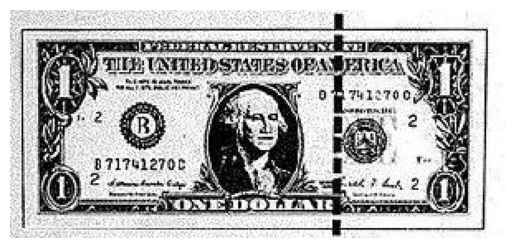

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

# Load and visualise the image
img = Image.open('dollar_image.jpg')

plt.imshow(img)
plt.axis('off')

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

print(transform(img))
print(transform(img).shape)

# conv_layer = nn.Conv2d()

tensor([[[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.3255, 1.0000,  ..., 0.9451, 0.9608, 0.9843],
         [0.5373, 0.9059, 0.3333,  ..., 1.0000, 1.0000, 1.0000],
         [0.9059, 0.6000, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 0.3255, 1.0000,  ..., 0.9451, 0.9608, 0.9843],
         [0.5373, 0.9059, 0.3333,  ..., 1.0000, 1.0000, 1.0000],
         [0.9059, 0.6000, 0.9529,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.4902, 0.6549, 0.4118,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.1765, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4196, 1.0000, 0.8353,  ..., 1.0000, 1.0000, 1.

We can see that our transform has converted our image into a PyTorch tensor, which has 3 channels and is a 138 by 300 image. We will now define a 2D convolutional layer with two different kernels, which are the Sobel operators. We will apply this layer to our image and then visualise the output. We will use a padding of 1 to keep our output the same size.

In [3]:
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 2,
                       kernel_size = 3,
                       padding = 1)

print(conv_layer.weight)

Parameter containing:
tensor([[[[ 0.1894,  0.0839,  0.0191],
          [-0.1511, -0.1053, -0.1487],
          [-0.0010,  0.1817, -0.1238]],

         [[-0.0642, -0.1024, -0.0816],
          [-0.1510, -0.1249, -0.1408],
          [-0.1300,  0.0934,  0.1800]],

         [[ 0.0747, -0.0972,  0.0713],
          [-0.1027, -0.1875, -0.1171],
          [-0.1361, -0.0604,  0.0696]]],


        [[[ 0.1310,  0.1085, -0.1296],
          [-0.0332,  0.0533, -0.0950],
          [-0.1893,  0.0105, -0.0524]],

         [[ 0.1169, -0.0849,  0.1871],
          [ 0.0490,  0.1282, -0.1825],
          [ 0.0972, -0.1905, -0.1408]],

         [[ 0.0218,  0.0681, -0.0950],
          [-0.0330,  0.0181,  0.1469],
          [-0.0988, -0.1484, -0.0374]]]], requires_grad=True)


In [4]:
sobel_horizontal = torch.tensor([[-1.,0.,1.],
                                 [-2., 0., 2.],
                                 [-1., 0., 1.]])

sobel_vertical = sobel_horizontal.T

# Need to replicate kernel for each channel
sobel_horizontal = sobel_horizontal.view(1, 1, 3, 3).repeat(1, 3, 1, 1) 
sobel_vertical = sobel_vertical.view(1, 1, 3, 3).repeat(1, 3, 1, 1)

weights = torch.concat([sobel_horizontal, sobel_vertical], dim = 0)

conv_layer.weight = nn.Parameter(weights)

In [5]:
feature_map = conv_layer(transform(img))

print(feature_map.shape)

torch.Size([2, 138, 300])


In order to plot these images, we need to normalise them to the 0 to 1 range. We will define a custom function to go from our feature map to an image we can plot, using `torchvision.utils.make_grid`.

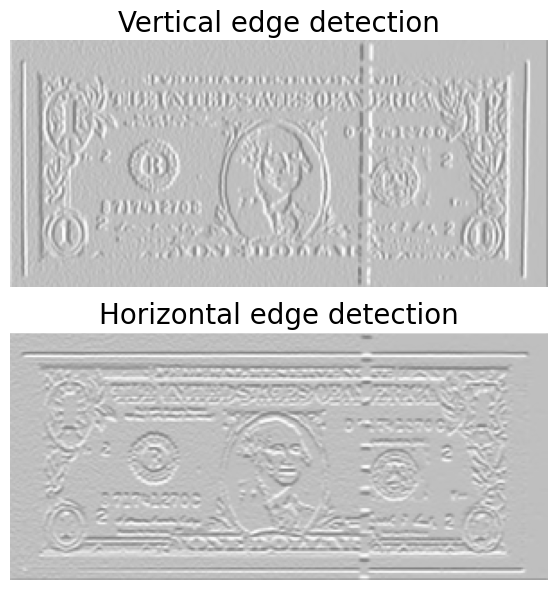

In [6]:
import numpy as np

def imshow(img, ax):
    '''Visualise a feature map after applying torchvision.utils.make_grid to it. 
    
    Inputs:
        img : output from torchvision.utils.make_grid
        ax : Axes object in your plot
    
    '''
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # Return tensor to numpy array
    ax.imshow(np.transpose(npimg, (1, 2, 0)))

fig, axs = plt.subplots(2,1, figsize = (6, 6), dpi = 100)
    
imshow(torchvision.utils.make_grid(feature_map[0], normalize = True, nrow = 3), axs[0])
imshow(torchvision.utils.make_grid(feature_map[1], normalize = True, nrow = 3), axs[1])
for ax in axs:
    ax.axis('off')

axs[0].set_title('Vertical edge detection',fontsize = 20)
axs[1].set_title('Horizontal edge detection',fontsize = 20)

fig.tight_layout()


<div style="background-color:#C2F5DD">

## Example
    
Now try playing around with the kernels in our convolutional layer and see what kind of feature maps you can produce. There is a list of kernels [here](https://en.wikipedia.org/wiki/Kernel_(image_processing)) that could be useful. 

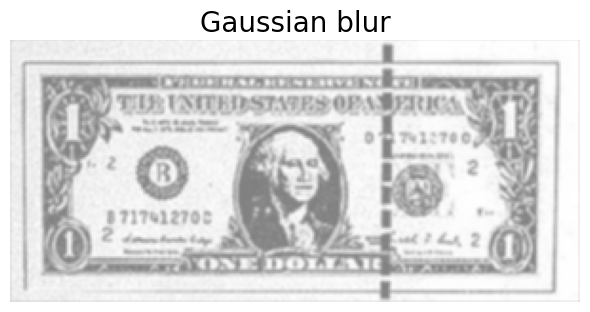

In [7]:
# Your code here
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 1,
                       kernel_size = 3,
                       padding = 1)

Gaussian_blur = torch.tensor([[1.,2.,1.],
                              [2.,4.,2.],
                              [1.,2.,1.]])

# Need to replicate kernel for each channel
Gaussian_blur = Gaussian_blur.view(1, 1, 3, 3).repeat(1, 3, 1, 1)

conv_layer.weight = nn.Parameter(Gaussian_blur)

# conv_layer.bias = nn.Parameter(torch.zeros(1))

feature_map = conv_layer(transform(img))

fig, axs = plt.subplots(1,1, figsize = (6, 6), dpi = 100)

imshow(torchvision.utils.make_grid(feature_map, normalize = True, nrow = 3), axs)

axs.axis('off')
axs.set_title('Gaussian blur',fontsize = 20)

fig.tight_layout()
plt.show()


<div style="background-color:#C2F5DD">
    
End of example

Using padding for CNNs in PyTorch is straightforward; you can do so either when you apply a convolutional layer, by specifying the padding size with the `padding` argument and specifying the padding mode with `padding_mode`, or by explicitly adding padding layers into your `nn.Sequential`. In general it is easiest to just add it into your convolutional layers. An example of two models that have the same net action is shown in the cell below. We will show they are the same by operating on some random data and showing the result is the same.

Note: we also highlight a slightly different syntax for the kernel size here; where before we passed a single number, here we pass a tuple. If we were to pass a single number, `Conv2d` assumes we have a square kernel with side length equal to the number we passed. By passing a tuple, we can specity the width and height of our kernel separately and so could have a non-square one if we wished.

In [8]:
# Use manual seeds to ensure kernel initial weights are the same
torch.manual_seed(1)
model_1 = nn.Conv2d(in_channels = 3,
                    out_channels = 1,
                    kernel_size = (3, 3),
                    stride = 1,
                    padding = 2,
                    padding_mode='zeros')

torch.manual_seed(1)
model_2 = nn.Sequential(nn.ZeroPad2d(padding = 2),
                        nn.Conv2d(in_channels = 3,
                                  out_channels = 1,
                                  kernel_size = (3, 3),
                                  stride = 1))

# Generate random data in 3 x 10 x 10 tensor
torch.manual_seed(1)
example_arr = torch.randn(3, 10, 10)


# Operate each model on the example array and compare to make sure results are the same
print(model_1(example_arr)==model_2(example_arr))



tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True],
         [True, True, True, True, True, True, True, True, True, True, 

Finally, we can define pooling layers using e.g. `nn.MaxPool2d`. You can read about more pooling options in the [documentation](https://pytorch.org/docs/stable/nn.html#pooling-layers). We can therefore put together a whole convolutional neural network using convolutional layers, padding, and max pooling. Because we have pooled using a 2 x 2 kernel, with a stride of 2, we should expect our output dimensions to be half of what they were after the previous model. 

In [9]:
# Fix manual seed to compare with previous models
torch.manual_seed(1)
model_3 = nn.Sequential(nn.Conv2d(in_channels = 3,
                                  out_channels = 1,
                                  kernel_size = (3, 3),
                                  stride = 1,
                                  padding = 2, 
                                  padding_mode = 'zeros'),
                        nn.MaxPool2d(kernel_size = (2, 2),
                                     stride = 2))

print('Example array shape: {}'.format(example_arr.shape))
print('Model 1 output shape: {}'.format(model_1(example_arr).shape))
print('Model 2 output shape: {}'.format(model_2(example_arr).shape))
print('Model 3 output shape: {}'.format(model_3(example_arr).shape))

Example array shape: torch.Size([3, 10, 10])
Model 1 output shape: torch.Size([1, 12, 12])
Model 2 output shape: torch.Size([1, 12, 12])
Model 3 output shape: torch.Size([1, 6, 6])


## Summary

In this section, we have briefly discussed convolutional neural networks in PyTorch, including:

* An introduction to the `torchvision` library, including datasets, popular pre-trained models, and transformations for computer vision
* How to define convolutional layers in PyTorch
* How to build a complete convolutional network with stride, padding, and pooling

In the next section, we will work through an example of a full convolutional neural network for the FashionMNIST dataset.

<hr style="border:2px solid gray">


# Section Three: A convolutional neural network example with Fashion MNIST [^](#outline) <a id='section-3'></a>

Now that we have the machinery to build a convolutional neural network in PyTorch, we will try training a model on the FashionMNIST dataset. Rather than the binary classification problems we have done in the past, this time we will be trying a multiclass classification problem. The principles for evaluating a model here are applicable to all multiclass classification problems.

We previously flattened images into 1D arrays when we used a standard neural network, we can instead use the full 2D datasets. We will need to do some standard transforms first:

In [10]:
import torchvision
import torch.nn as nn
import torch
from torchvision.datasets import FashionMNIST

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

train_dataset = FashionMNIST(root='Week10_data', train=True, transform=transform, download=True)
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, lengths = [0.8, 0.2], generator = torch.Generator().manual_seed(1))

test_dataset = FashionMNIST(root='Week10_data',train = False, transform = transform, download = True)

We will first define a a simple FashionMNIST model and train it, and then you will define a model according to some guidance.

In [11]:
# Simple model
torch.manual_seed(1)

fashion_mnist_model_1 = nn.Sequential(nn.Conv2d(in_channels = 1,
                                                out_channels = 6,
                                                kernel_size = 5),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size = 2,
                                                   stride = 2),
                                      nn.Flatten(start_dim = 1), # Flatten all dimensions but batch
                                      nn.Linear(in_features = 6 * 12 * 12,
                                                out_features = 10)) # Size 10 output to give an output for each class

In [12]:
# Define DataLoaders

train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
val_dloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle = True, drop_last = True)
test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False, generator = torch.Generator().manual_seed(1))

In [13]:
# Define loss function and optimizer

loss_fcn = nn.CrossEntropyLoss(reduction='sum')
optimizer = torch.optim.SGD(params = fashion_mnist_model_1.parameters(), lr = 0.001, momentum = 0.9)

In [14]:
# from tqdm import tqdm

def train_epoch(model, optimizer, epoch):
    tot_loss = 0
    valid_loss = 0
    true_preds, count = 0., 0
    model.train()
    for X_train, y_train in (train_dloader):
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train)
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
        true_preds += (y_pred.argmax(dim = -1)==y_train).sum()
        count += y_train.shape[0]
    train_acc = true_preds/count

    vtrue_preds, vcount = 0., 0
    model.eval()
    for X_valid, y_valid in val_dloader:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid)
        valid_loss += vloss.detach()
        vtrue_preds += (y_pred_v.argmax(dim = -1)==y_valid).sum()
        vcount += y_valid.shape[0]
    val_acc = vtrue_preds/vcount

        
    print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

    
    return tot_loss/len(train_dataset), valid_loss/len(validation_dataset)

In [15]:
for i in range(2):
    train_epoch(fashion_mnist_model_1, optimizer, i)

[Epoch  1] Training accuracy: 82.40%, Validation accuracy: 85.25%
[Epoch  2] Training accuracy: 85.81%, Validation accuracy: 85.37%


Now that we have trained a model (for only 2 epochs), we can quickly evaluate the performance on the test data. We will start by visualising a few images and then making prediction on those points, and then evaluating the test performance on the whole dataset. 

tensor([9, 2, 1, 1])


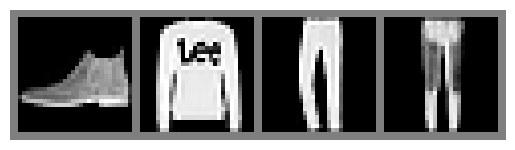

In [16]:
test_iter = iter(test_dloader)
images, labels = next(test_iter)

fig, ax = plt.subplots(1,1)
plt.axis('off')
imshow(torchvision.utils.make_grid(images),ax)

print(labels)

In [17]:
fashion_mnist_model_1.eval()

outputs = fashion_mnist_model_1(images)

print(outputs)

tensor([[-2.7063, -4.3678, -2.3069, -2.3369, -4.3371,  4.3779, -3.3659,  4.1948,
          1.0209,  9.6513],
        [ 3.8806, -2.0651, 14.2842, -0.4872,  3.2141, -7.6921,  2.7750, -6.5638,
         -2.0381, -5.7406],
        [ 0.7750, 14.9556, -2.3121,  1.9104,  0.8079, -3.4872, -2.0651, -2.4827,
         -2.4700, -4.7589],
        [ 0.1251, 14.6900, -2.7565,  1.0261, -0.0971, -2.3709, -1.7223, -2.3613,
         -4.3232, -2.3391]], grad_fn=<AddmmBackward0>)


For each sample, we output a vector of length 10, where each value corresponds to the "energy" for one of the classes. The higher the energy, the more the network thinks the sample belongs to that class. We can therefore make predictions by selecting the class with the highest entropy, using `torch.argmax`: 

In [18]:
torch.argmax(outputs, dim = -1)

tensor([9, 2, 1, 1])

We can therefore see we have successfully predicted those four points. We can now iterate over the whole training dataset and calculate the total test classification accuracy:

In [19]:
total_correct, total_pred = 0, 0

fashion_mnist_model_1.eval()
with torch.no_grad(): # no need to calculate gradients as we are just evaluating
    for X_batch, y_batch in test_dloader:
        pred = torch.argmax(fashion_mnist_model_1(X_batch), dim = -1)
        total_correct += (pred==y_batch).sum()
        total_pred+=len(y_batch)
        
print('Classification accuracy on test data = {:.2f}%'.format(total_correct/total_pred * 100))
        

Classification accuracy on test data = 85.11%


Even after only training for 2 epochs, we have more than 80% classification accuracy on test data. We will also try evaluating the performance per-class, to see if there is anywhere we make particular mistakes.

In [20]:
classes = ('t-shirt/top', 'trouser', 'pullover', 'dress',
           'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot')

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for images, labels in test_dloader:
        outputs = fashion_mnist_model_1(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: t-shirt/top is 78.3 %
Accuracy for class: trouser is 96.2 %
Accuracy for class: pullover is 86.1 %
Accuracy for class: dress is 91.9 %
Accuracy for class: coat  is 62.2 %
Accuracy for class: sandal is 96.8 %
Accuracy for class: shirt is 56.4 %
Accuracy for class: sneaker is 90.9 %
Accuracy for class: bag   is 95.3 %
Accuracy for class: ankle boot is 97.0 %


We can also use some useful functions from scikit-learn to plot the confusion matrix, to see exactly how we can get things wrong. We previously only discussed the confusion matrix in the context of binary classification problems, but here we can produce the same results for a multiclass classification problem.

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test, preds = [], []
for images, labels in test_dloader:
    y_test.append(labels)
    preds.append(torch.max(fashion_mnist_model_1(images),1)[1])
    
y_test = torch.concat(y_test).flatten()
preds = torch.concat(preds).flatten()

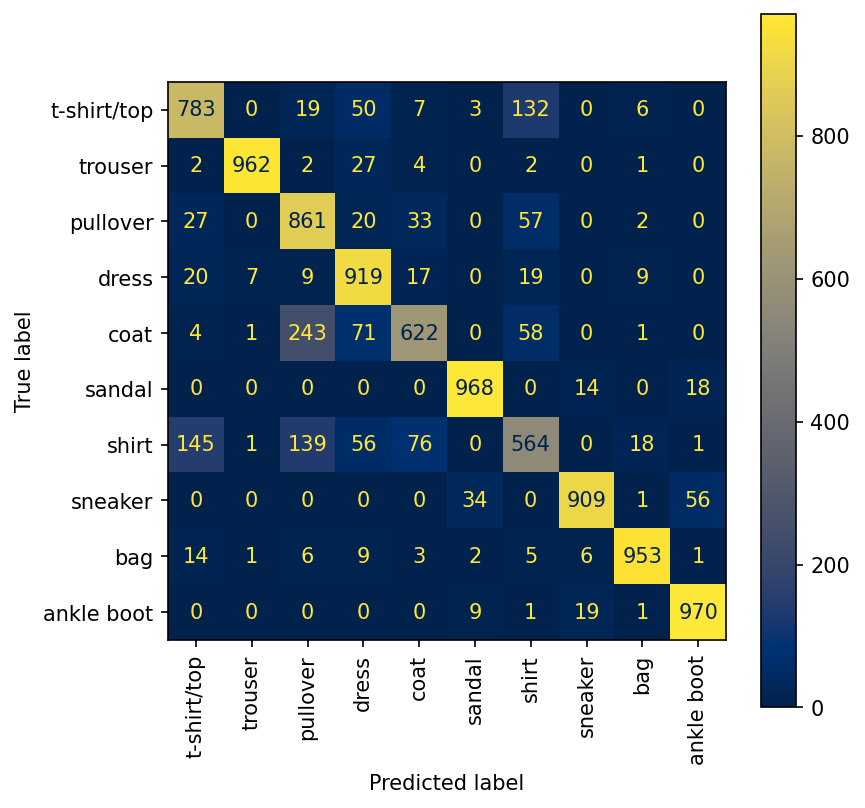

In [22]:
fig, ax = plt.subplots(1,1, figsize = (6,6),dpi = 150)

cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')

This allows us to visualise how our model is making mistakes. For example, we are often predicting samples in the t-shirts/tops category as shirts (referring to button-up shirts). 

Finally, if we convert the output of our CNN to a normalised probability per class, we can plot ROC curves and calculate ROC-AUC scores for each class. We will do this conversion using [`nn.functional.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html). You can also add this into your `nn.Sequential` using [`nn.Softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax).

In [23]:
probs = []
for images, labels in test_dloader:
    outputs = nn.functional.softmax(fashion_mnist_model_1(images), dim = -1)
    probs.append(outputs)
    
probs = torch.concat(probs, dim = 0)

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve

# specify multi_class = 'ovr' to calculate roc-auc score in a "one-vs-rest" scheme i.e. the "true" class is one class, 
# and the "false" class is all the other classes
roc_auc_scores = roc_auc_score(y_test.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)

for i in range(10):
    print('ROC-AUC score for {} class = {:.5f}'.format(classes[i], roc_auc_scores[i]))

ROC-AUC score for t-shirt/top class = 0.98110
ROC-AUC score for trouser class = 0.99910
ROC-AUC score for pullover class = 0.97375
ROC-AUC score for dress class = 0.99097
ROC-AUC score for coat class = 0.97347
ROC-AUC score for sandal class = 0.99903
ROC-AUC score for shirt class = 0.94002
ROC-AUC score for sneaker class = 0.99766
ROC-AUC score for bag class = 0.99737
ROC-AUC score for ankle boot class = 0.99874


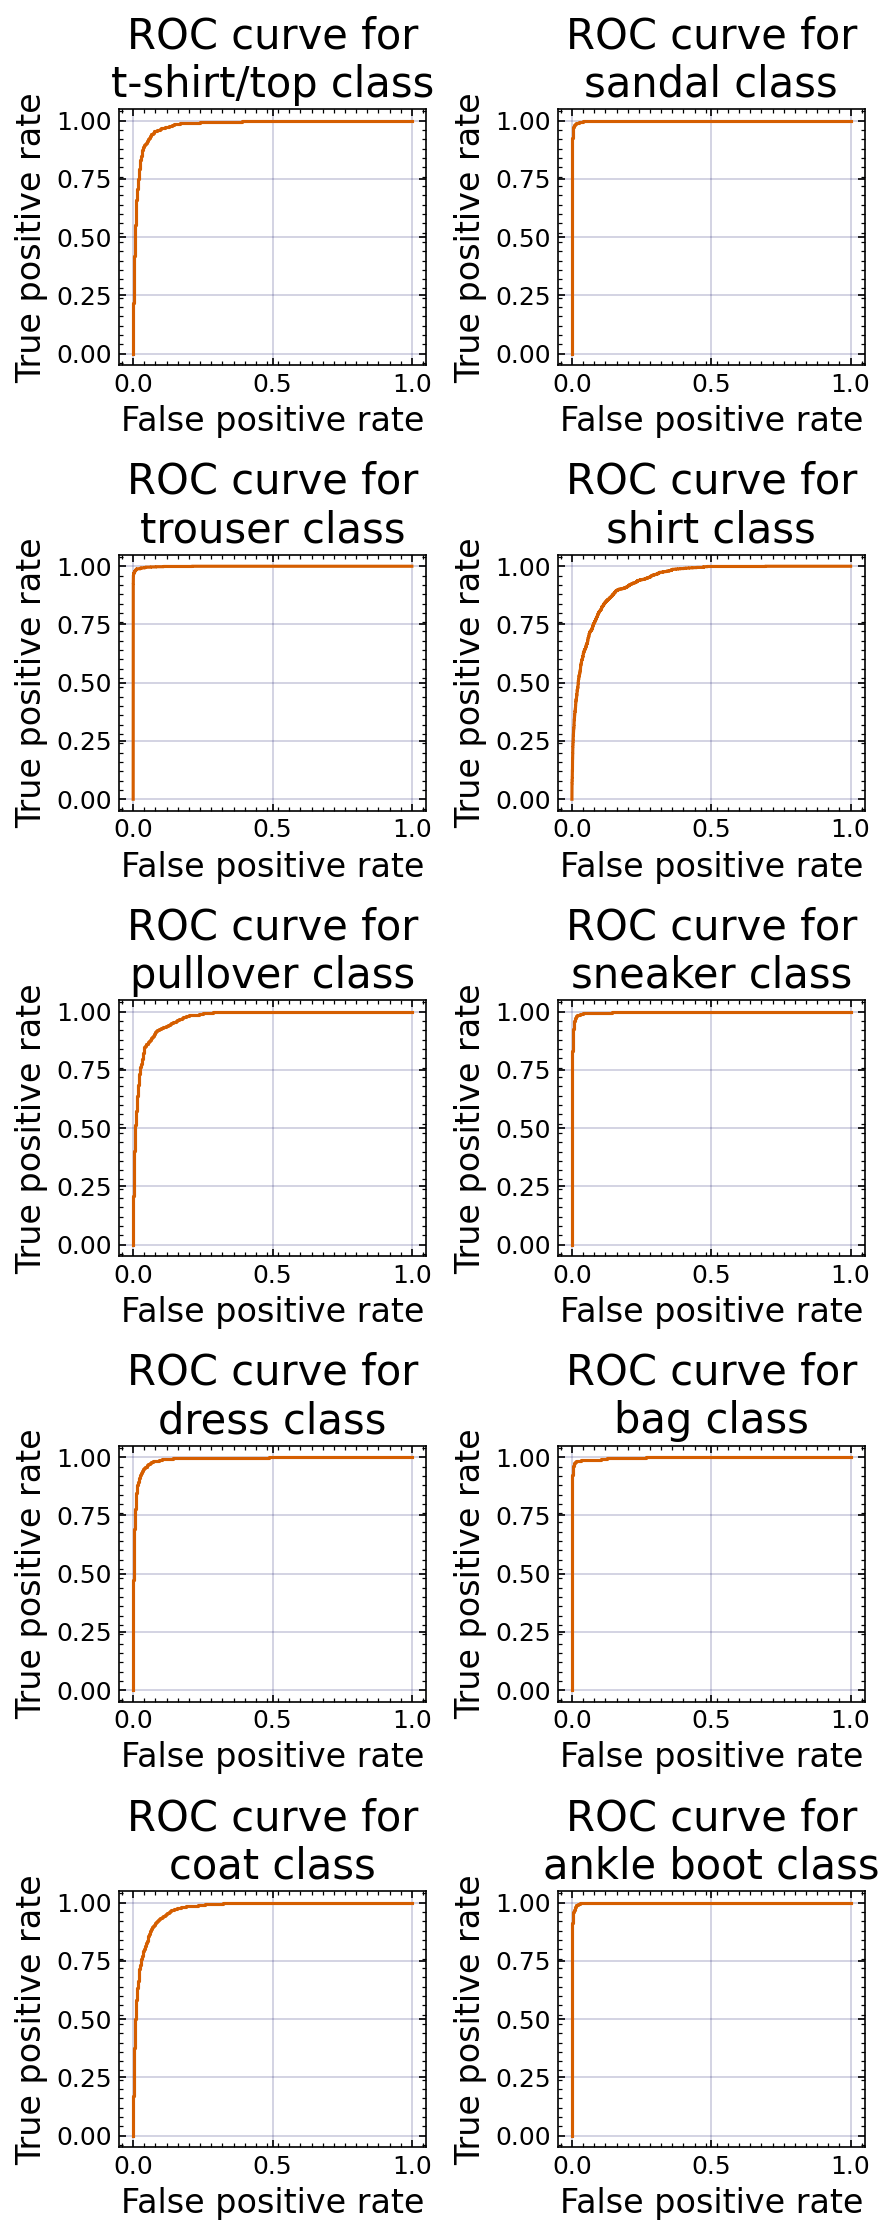

In [25]:
from matplotlib.ticker import MultipleLocator

fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)
        
fig.tight_layout()

As we thought from the classification accuracy and the confusion matrix, we can see that the worst performance is for the shirt class and the coat class. Rather than just relying on the overall classification rate for a multiclass classification problem it is important to look at the performance per class to see if there are any particular mistakes made by the network.

<div style="background-color:#C2F5DD">

## Example
    
Now that you have seen the process for training and evaluating a convolutional neural network for this dataset, try varying the architecture of the network. In particular, try changing:

* the number of output channels from the first convolutional layer
* the number of convolutional layers
* the number of linear layers at the end of the network
* the choice of type of pooling (e.g. max or average)
    
Make sure every convolutional or linear layer is followed by a ReLU activation function. Use the `CrossEntropyLoss` loss function.
    
Train your model for 2 epochs, then evaluate the following metrics:
    
* total classification accuracy
* confusion matrix
* ROC-AUC scores per class
* ROC curves for each class
    
Save your best performing architecture using `torch.save`. See the [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for more details.

In [26]:
# Define model
torch.manual_seed(1)
model_4 = nn.Sequential(nn.Conv2d(in_channels = 1,
                                    out_channels = 6,
                                    kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Conv2d(in_channels = 6,
                                    out_channels = 16,
                                    kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Flatten(start_dim = 1),
                            nn.Linear(in_features = 16 * 4 * 4,
                                    out_features = 120),
                            nn.ReLU(),
                            nn.Linear(in_features = 120,
                                    out_features = 84),
                            nn.ReLU(),
                            nn.Linear(in_features = 84,
                                    out_features = 10))

In [27]:
# Define optimizer

optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.001, momentum = 0.9)

In [28]:
# Define loss function

loss_fcn = nn.CrossEntropyLoss(reduction='sum')

In [29]:
# Define training loop

def train_epoch(model, optimizer, epoch):
    tot_loss = 0
    valid_loss = 0
    true_preds, count = 0., 0
    model.train()
    for X_train, y_train in (train_dloader):
        y_pred = model(X_train)
        optimizer.zero_grad()
        loss = loss_fcn(y_pred, y_train)
        tot_loss += loss.detach()
        loss.backward()
        optimizer.step()
        true_preds += (y_pred.argmax(dim = -1)==y_train).sum()
        count += y_train.shape[0]
    train_acc = true_preds/count

    vtrue_preds, vcount = 0., 0
    model.eval()
    for X_valid, y_valid in val_dloader:
        y_pred_v = model(X_valid)
        vloss = loss_fcn(y_pred_v, y_valid)
        valid_loss += vloss.detach()
        vtrue_preds += (y_pred_v.argmax(dim = -1)==y_valid).sum()
        vcount += y_valid.shape[0]
    val_acc = vtrue_preds/vcount

        
    print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

    
    return tot_loss/len(train_dataset), valid_loss/len(validation_dataset)

In [30]:
# Train model

for i in range(2):
    train_epoch(model_4, optimizer, i)

[Epoch  1] Training accuracy: 75.40%, Validation accuracy: 84.21%
[Epoch  2] Training accuracy: 84.66%, Validation accuracy: 85.24%


In [31]:
# Evaluate whole classification accuracy on test data

total_correct, total_pred = 0, 0

model_4.eval()
with torch.no_grad(): # no need to calculate gradients as we are just evaluating
    for X_batch, y_batch in test_dloader:
        pred = torch.argmax(model_4(X_batch), dim = -1)
        total_correct += (pred==y_batch).sum()
        total_pred+=len(y_batch)

print('Classification accuracy on test data = {:.2f}%'.format(total_correct/total_pred * 100))



Classification accuracy on test data = 84.61%


In [32]:
# Evaluate classification accuracy per class and the confusion matrix

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for images, labels in test_dloader:
        outputs = model_4(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: t-shirt/top is 88.1 %
Accuracy for class: trouser is 96.1 %
Accuracy for class: pullover is 79.4 %
Accuracy for class: dress is 80.8 %
Accuracy for class: coat  is 81.3 %
Accuracy for class: sandal is 96.0 %
Accuracy for class: shirt is 41.8 %
Accuracy for class: sneaker is 95.9 %
Accuracy for class: bag   is 95.3 %
Accuracy for class: ankle boot is 91.4 %


In [33]:
# Evaluate ROC-AUC score and plot ROC curve per class

probs = []
for images, labels in test_dloader:
    outputs = nn.functional.softmax(model_4(images), dim = -1)
    probs.append(outputs)

probs = torch.concat(probs, dim = 0)

roc_auc_scores = roc_auc_score(y_test.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)

for i in range(10):
    print('ROC-AUC score for {} class = {:.5f}'.format(classes[i], roc_auc_scores[i]))
    

ROC-AUC score for t-shirt/top class = 0.98306
ROC-AUC score for trouser class = 0.99852
ROC-AUC score for pullover class = 0.97885
ROC-AUC score for dress class = 0.98872
ROC-AUC score for coat class = 0.97481
ROC-AUC score for sandal class = 0.99905
ROC-AUC score for shirt class = 0.93940
ROC-AUC score for sneaker class = 0.99779
ROC-AUC score for bag class = 0.99635
ROC-AUC score for ankle boot class = 0.99796


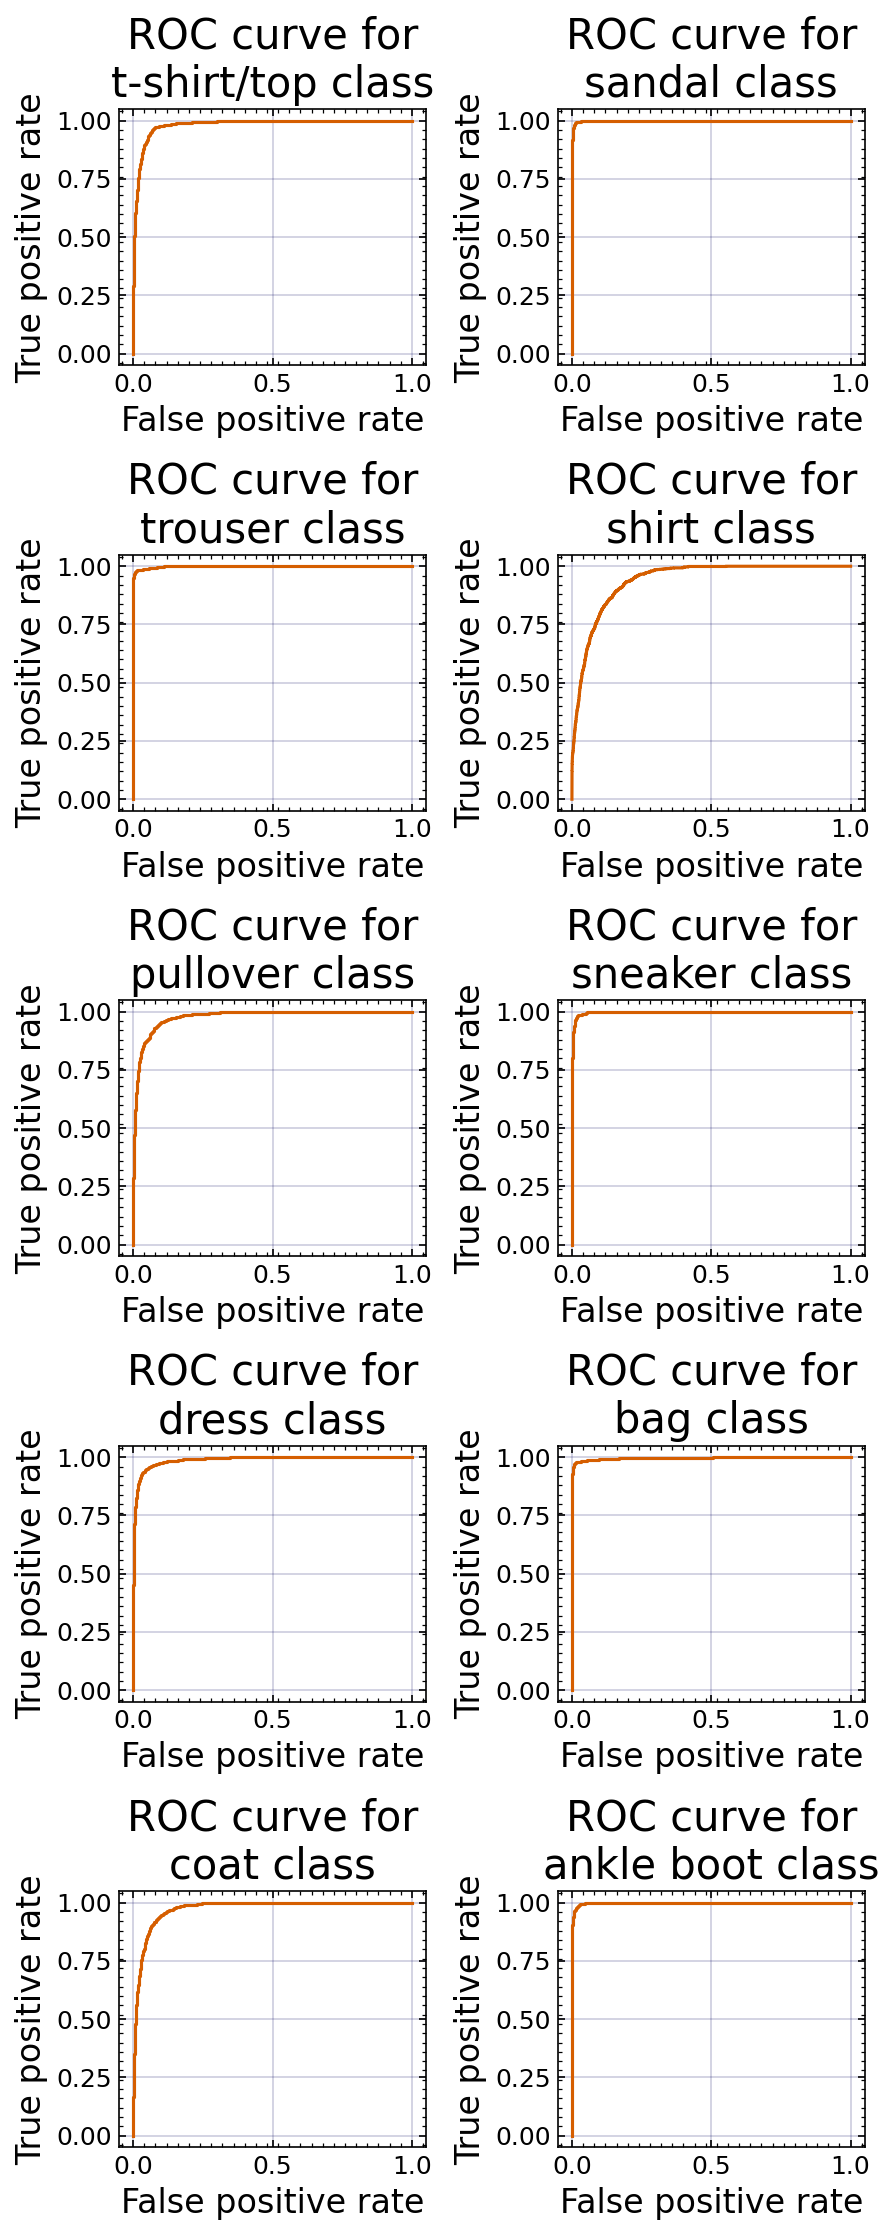

In [34]:
# plot ROC curve for each class

fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)

fig.tight_layout()

<div style="background-color:#C2F5DD">

End of example

## Summary

In this section, we have presented an example convolutional neural network for the FashionMNIST dataset, including:

* How to define a full convolutional neural network
* How to write a training loop for this network
* How to evaluate performance of the model on test data, both for all test samples and per individual class

In the following section, we will introduce the CIFAR-10 dataset that you will work with for the exercises this week.

<hr style="border:2px solid gray">

# Section Four: The CIFAR-10 dataset[^](#outline) <a id='section-4'></a>

The CIFAR-10 dataset (Canadian Institute for Advanced Research) is a collection of images that is commonly used for testing computer vision algorithms, often convolutional neural networks. It is composed of 60,000 32 x 32 colour images, each belonging to one of 10 classes. The classes are airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks, and each class has 6000 images. The data is split into a training dataset of 50,000 images and a test dataset of 10,000 images.

This dataset is available in `torchvision`, and is easy to load in:

In [35]:
# If you see an SSL certificate error, uncomment these lines

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import torchvision
import torchvision.transforms as transforms

# Define transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])


# Download data
train_dataset = torchvision.datasets.CIFAR10(root='Week10_data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='Week10_data', train = False, download = True, transform = transform)

test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We will quickly visualise some of the samples:

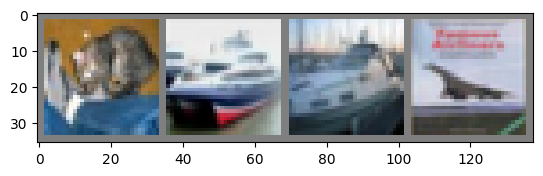

cat   ship  ship  plane


In [36]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(test_dloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Summary

In this section we have introduced the CIFAR-10 dataset, which you will use for the exercises this week.

The following section details the exercises for you to work through this week.


<hr style="border:2px solid gray">

# Section Five: Exercises[^](#outline) <a id='section-5'></a>

The exercises this week will step you through building a neural network and training it on the CIFAR-10 dataset, as well as evaluating the performance and trying different architectures.

<div style="background-color:#C2F5DD">

## Exercise 1
    
Using `nn.Sequential`, define a convolutional neural network with the following structure:
    
* Convolutional layer with 3 input channels, 6 output channels, and a 5 x 5 kernel
* ReLU activation function
* Max pooling layer with a 2 x 2 kernel and a stride of 2
* Convolutional layer with 6 input channels, 16 output channels, and a 5 x 5 kernel
* ReLU activation function
* Max pooling layer with a 2 x 2 kernel and a stride of 2
* Flatten layer (flatten along all dimensions apart from the batch using `nn.Flatten`)
* Linear layer with an input size appropriate to the output of the previous layers (hint: multiply number of channels, width, and depth of the output from previous layers) and an output size of 120
* ReLU activation function
* Linear layer with 120 inputs and 84 outputs
* ReLU activation function
* Linear layer with 84 inputs and 10 outputs
    
Remember to fix your random seed for reproducibility.


In [37]:
# Your model code here
torch.manual_seed(1)
model_ex = nn.Sequential(nn.Conv2d(in_channels = 3,
                                    out_channels = 6,
                                    kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Conv2d(in_channels = 6,
                                      out_channels = 16,
                                      kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.MaxPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Flatten(start_dim = 1),
                            nn.Linear(in_features = 16 * 5 * 5,
                                      out_features = 120),
                            nn.ReLU(),
                            nn.Linear(in_features = 120,
                                      out_features = 84),
                            nn.ReLU(),
                            nn.Linear(in_features = 84,
                                      out_features = 10))

<div style="background-color:#C2F5DD">

## Exercise 2
    
Using `random_split` from `torch.utils.data`, split the training dataset into training and validation datasets with an 80:20 split. Then define DataLoaders for the training and validation data, each with a batch size of 64. Remember that the training and validation DataLoaders should shuffle the order in which they show data, and to drop the last batch to account for the dataset size not being evenly divisible by the batch size.
    
Fix the random seed of the random split by supplying the `generator` argument (see the [documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)).

In [38]:
# Your data split

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, lengths = [0.8, 0.2], generator = torch.Generator().manual_seed(1))
                                                                

In [39]:
# Your DataLoaders

train_dloader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True, drop_last = True)
val_dloader = torch.utils.data.DataLoader(validation_dataset, batch_size = 64, shuffle = True, drop_last = True)
# test_dloader = torch.utils.data.DataLoader(test_dataset, batch_size = 4, shuffle = False, generator = torch.Generator().manual_seed(1))

<div style="background-color:#C2F5DD">

## Exercise 3
    
Now that you have set up your model and DataLoaders, it is time to train the model for 10 epochs. Follow these steps:
    
* Define your loss function and optimizer. Use the CrossEntropyLoss as your loss function, and SGD as your optimizer (with a learning rate of 0.001 and a momentum of 0.9). 
* Define a training loop function to train for a single epoch, calculating and returning the training and validation loss at the end of each epoch.
* Train your model for 10 epochs, making sure you record the training and validation loss returned by your training loop function.

In [40]:
# Define loss function and optimizer

loss_fcn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_ex.parameters(), lr = 0.001, momentum = 0.9)

In [41]:
# Define training loop function

def train_epoch(model, optimizer, loss_fcn, epochs):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        tloss, vloss = 0, 0
        true_preds, count = 0., 0

        model.train()
        for X_train, y_train in train_dloader:
            y_pred = model(X_train)
            optimizer.zero_grad()
            loss = loss_fcn(y_pred, y_train)
            tloss += loss.detach()
            loss.backward()
            optimizer.step()
            true_preds += (y_pred.argmax(dim = -1)==y_train).sum()
            count += y_train.shape[0]
        train_acc = true_preds/count

        model.eval()
        with torch.no_grad():
            vtrue_preds, vcount = 0., 0
            for X_valid, y_valid in val_dloader:
                y_pred_v = model(X_valid)
                vloss += loss_fcn(y_pred_v, y_valid).detach()
                vtrue_preds += (y_pred_v.argmax(dim = -1)==y_valid).sum()
                vcount += y_valid.shape[0]
        val_acc = vtrue_preds/vcount

        print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")
        train_losses.append(tloss/len(train_dataset))
        val_losses.append(vloss/len(validation_dataset))
    
    return train_losses, val_losses

In [42]:
# Train model for 10 epochs

train_losses, val_losses = train_epoch(model_ex, optimizer, loss_fcn, 10)

[Epoch  1] Training accuracy: 11.03%, Validation accuracy: 16.18%
[Epoch  2] Training accuracy: 18.61%, Validation accuracy: 21.64%
[Epoch  3] Training accuracy: 25.60%, Validation accuracy: 28.06%
[Epoch  4] Training accuracy: 31.10%, Validation accuracy: 33.01%
[Epoch  5] Training accuracy: 35.96%, Validation accuracy: 37.84%
[Epoch  6] Training accuracy: 39.71%, Validation accuracy: 40.73%
[Epoch  7] Training accuracy: 42.60%, Validation accuracy: 42.49%
[Epoch  8] Training accuracy: 45.14%, Validation accuracy: 45.29%
[Epoch  9] Training accuracy: 47.05%, Validation accuracy: 46.09%
[Epoch 10] Training accuracy: 48.80%, Validation accuracy: 47.89%


<div style="background-color:#C2F5DD">

## Exercise 4
    
Now you have trained your model, it is time to evaluate the performance. Calculate the following performance metrics:
    
* Total classification accuracy on test data
* Classification accuracy for each class
* ROC-AUC scores for each class
    
Also produce the following plots:

* Training and validation loss as a function of epoch
* Confusion matrix
* ROC curves for each class
    
Then, answer the following questions:
    
* Is your model overfitting at all? Do you think performance would improve if you were to train for more epochs?
* What classes does your model get confused between, if any?
* Which class has the worst performance?

In [46]:
# Calculate classification accuracy for all data and each class, and the ROC-AUC scores

from sklearn.metrics import roc_auc_score, accuracy_score

def evaluateModel(model):
    #     roc_aucs, pred_labels, probs, accs, y_t = [], [], [], [], []
    y_t, y_preds = [], []
    total_correct, total_count = 0., 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dloader:
            y_t.append(y_test)
            y_preds.append(model(X_test))
    y_t = torch.concat(y_t)
    y_preds = torch.concat(y_preds)
    probs = nn.functional.softmax(y_preds, dim = -1)
    pred_labels = y_preds.argmax(dim = -1)
    roc_aucs = roc_auc_score(y_t.detach().numpy(), probs.detach().numpy(), multi_class='ovr', average=None)
    accs = accuracy_score(y_t.detach().numpy(), pred_labels.detach().numpy())
    accs_per_class = [accuracy_score(y_t[y_t==i].detach().numpy(), pred_labels[y_t==i].detach().numpy()) for i in range(10)]
    
        
    return y_t, y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class

y_test,  y_preds, probs, pred_labels, roc_aucs, accs, accs_per_class = evaluateModel(model_ex)

print('Classification accuracy on test data = {:.2f}%'.format(accs * 100))
print('\n')

for i in range(10):
    print("For class{}: ".format(classes[i]))
    print(  'ROC-AUC score = {:.5f}'.format(roc_aucs[i]))
    print(  'Classification accuracy = {:.2f}%'.format(accs_per_class[i] * 100))
    print('\n')




Classification accuracy on test data = 48.62%


For classplane: 
ROC-AUC score = 0.90312
Classification accuracy = 52.70%


For classcar: 
ROC-AUC score = 0.93728
Classification accuracy = 54.20%


For classbird: 
ROC-AUC score = 0.81579
Classification accuracy = 23.20%


For classcat: 
ROC-AUC score = 0.82466
Classification accuracy = 33.90%


For classdeer: 
ROC-AUC score = 0.84499
Classification accuracy = 39.70%


For classdog: 
ROC-AUC score = 0.87413
Classification accuracy = 33.20%


For classfrog: 
ROC-AUC score = 0.91283
Classification accuracy = 70.20%


For classhorse: 
ROC-AUC score = 0.89346
Classification accuracy = 59.00%


For classship: 
ROC-AUC score = 0.92312
Classification accuracy = 63.10%


For classtruck: 
ROC-AUC score = 0.90623
Classification accuracy = 57.00%




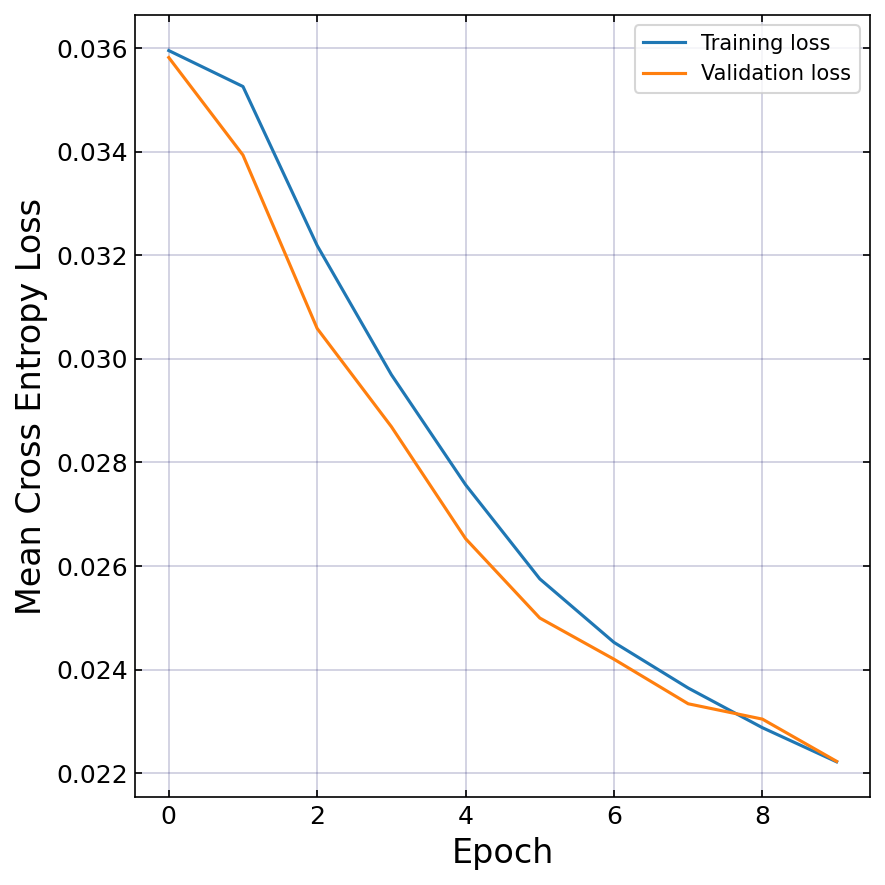

In [48]:
# Plot training & validation loss

fig, ax = plt.subplots(1,1, figsize = (6, 6), dpi = 150)

ax.plot(train_losses, label='Training loss')
ax.plot(val_losses, label='Validation loss')
ax.set_xlabel('Epoch', fontsize = 16)
ax.set_ylabel('Mean Cross Entropy Loss', fontsize = 16)
ax.legend()
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)

fig.tight_layout()



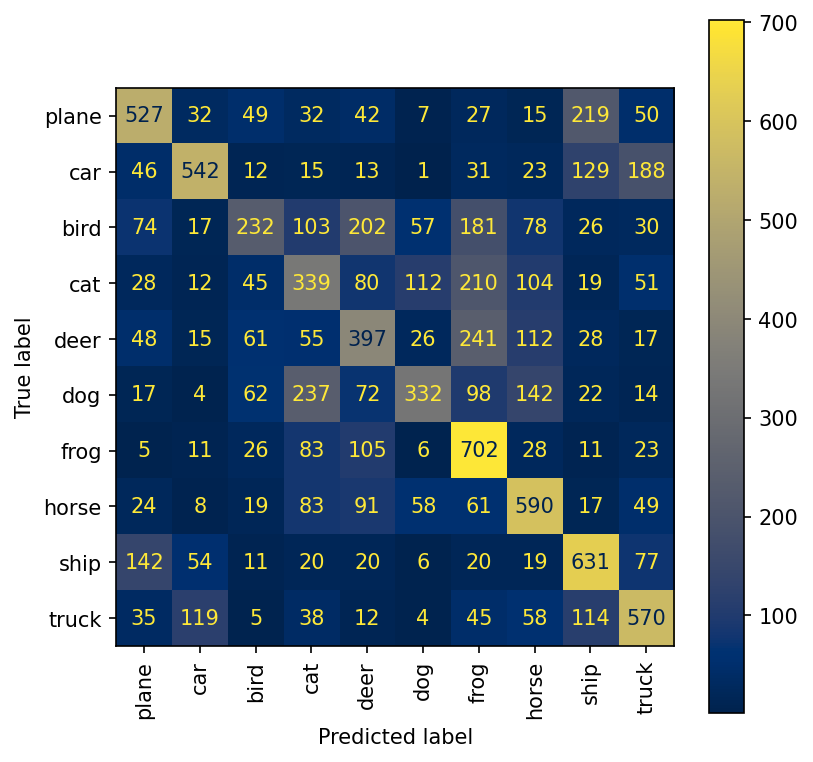

In [49]:
# Plot confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi = 150)

cm = confusion_matrix(y_test, pred_labels)
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')


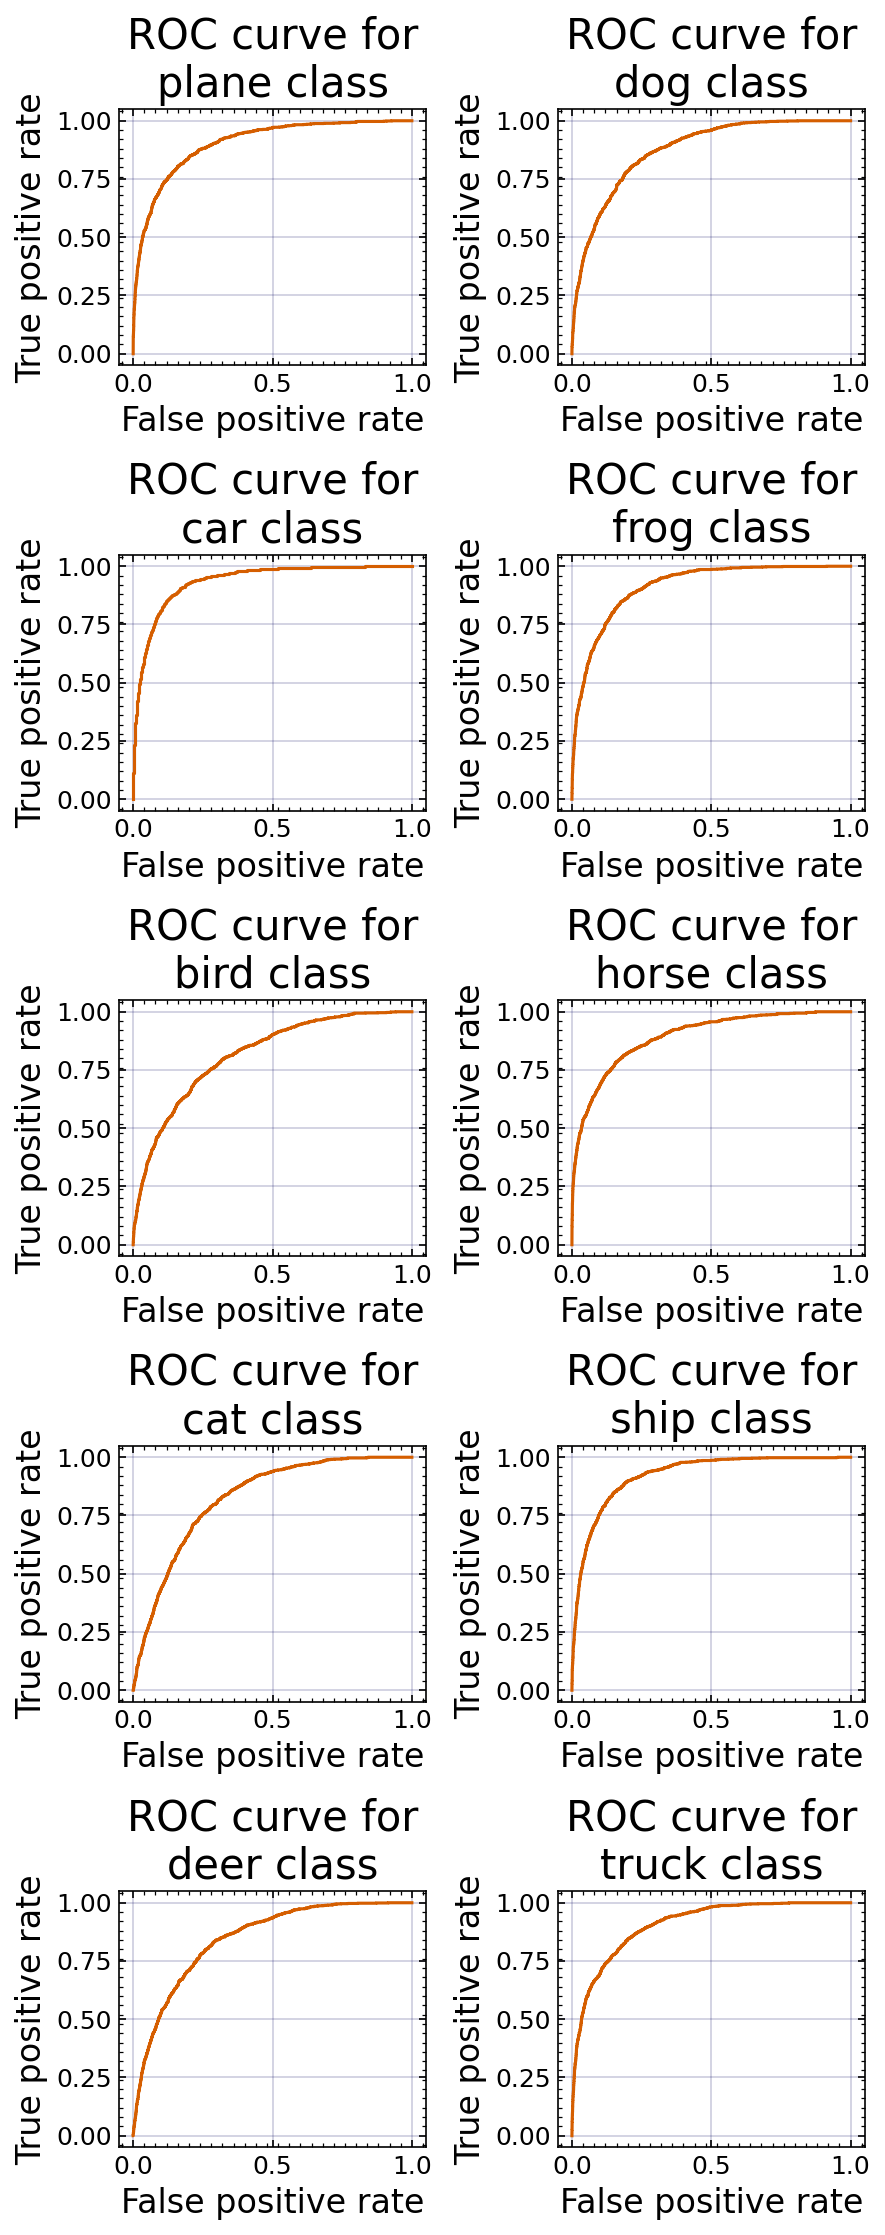

In [50]:
# Plot ROC curves

fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)
for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)    

fig.tight_layout()

Your answers here

<div style="background-color:#C2F5DD">

## Exercise 5
    
Now you have worked through the full process of training and evaluating a CNN on the CIFAR-10 data, we will try changing the network to see if we can find any improvement. First, we will try replacing the max pooling layers with average pooling layers, and otherwise keeping the network structure the same. 
    
Remember the following steps:

* Define your model, loss function and optimizer (fix seed to keep model parameters the same)
* Define your training loop
* Train for 10 epochs
* Calculate classification accuracy for all data and for each class, and calculate the ROC-AUC score for each class
* Plot the training and validation loss, confusion matrix, and ROC curves for each class
    
You should use the same model architecture as in Exercise 1, but replace the max pooling layers with average pooling layers. How does the performance compare for the model with max pooling?

In [51]:
# Define model
torch.manual_seed(1)
model_ex5 = nn.Sequential(nn.Conv2d(in_channels = 3,
                                    out_channels = 6,
                                    kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Conv2d(in_channels = 6,
                                      out_channels = 16,
                                      kernel_size = (5, 5)),
                            nn.ReLU(),
                            nn.AvgPool2d(kernel_size = (2, 2),
                                         stride = 2),
                            nn.Flatten(start_dim = 1),
                            nn.Linear(in_features = 16 * 5 * 5,
                                      out_features = 120),
                            nn.ReLU(),
                            nn.Linear(in_features = 120,
                                      out_features = 84),
                            nn.ReLU(),
                            nn.Linear(in_features = 84,
                                      out_features = 10))


# Define loss function & optimizer
optimizer_ex5 = torch.optim.SGD(params = model_ex5.parameters(), lr = 0.001, momentum = 0.9)
loss_fcn = nn.CrossEntropyLoss()

In [ ]:
# Define training loop

In [52]:
# Train for 10 epochs
train_losses_ex5, val_losses_ex5 = train_epoch(model_ex5, optimizer_ex5, loss_fcn, 10)

[Epoch  1] Training accuracy: 10.59%, Validation accuracy: 10.82%
[Epoch  2] Training accuracy: 15.26%, Validation accuracy: 17.63%
[Epoch  3] Training accuracy: 20.43%, Validation accuracy: 25.23%
[Epoch  4] Training accuracy: 26.95%, Validation accuracy: 28.78%
[Epoch  5] Training accuracy: 30.12%, Validation accuracy: 32.23%
[Epoch  6] Training accuracy: 33.53%, Validation accuracy: 34.40%
[Epoch  7] Training accuracy: 36.73%, Validation accuracy: 37.20%
[Epoch  8] Training accuracy: 39.65%, Validation accuracy: 40.21%
[Epoch  9] Training accuracy: 42.31%, Validation accuracy: 42.30%
[Epoch 10] Training accuracy: 44.19%, Validation accuracy: 44.09%


In [53]:
# Calculate performance metrics

y_test_ex5,  y_preds_ex5, probs_ex5, pred_labels_ex5, roc_aucs_ex5, accs_ex5, accs_per_class_ex5 = evaluateModel(model_ex5)

print('Classification accuracy on test data = {:.2f}%'.format(accs_ex5 * 100))

for i in range(10):
    print("For class{}: ".format(classes[i]))
    print(  'ROC-AUC score = {:.5f}'.format(roc_aucs_ex5[i]))
    print(  'Classification accuracy = {:.2f}%'.format(accs_per_class_ex5[i] * 100))
    print('\n')

Classification accuracy on test data = 44.98%
For classplane: 
ROC-AUC score = 0.88617
Classification accuracy = 46.60%


For classcar: 
ROC-AUC score = 0.91270
Classification accuracy = 50.80%


For classbird: 
ROC-AUC score = 0.80866
Classification accuracy = 23.80%


For classcat: 
ROC-AUC score = 0.79979
Classification accuracy = 31.60%


For classdeer: 
ROC-AUC score = 0.82489
Classification accuracy = 39.30%


For classdog: 
ROC-AUC score = 0.84608
Classification accuracy = 29.60%


For classfrog: 
ROC-AUC score = 0.89727
Classification accuracy = 64.70%


For classhorse: 
ROC-AUC score = 0.87219
Classification accuracy = 51.90%


For classship: 
ROC-AUC score = 0.90115
Classification accuracy = 62.50%


For classtruck: 
ROC-AUC score = 0.88131
Classification accuracy = 49.00%




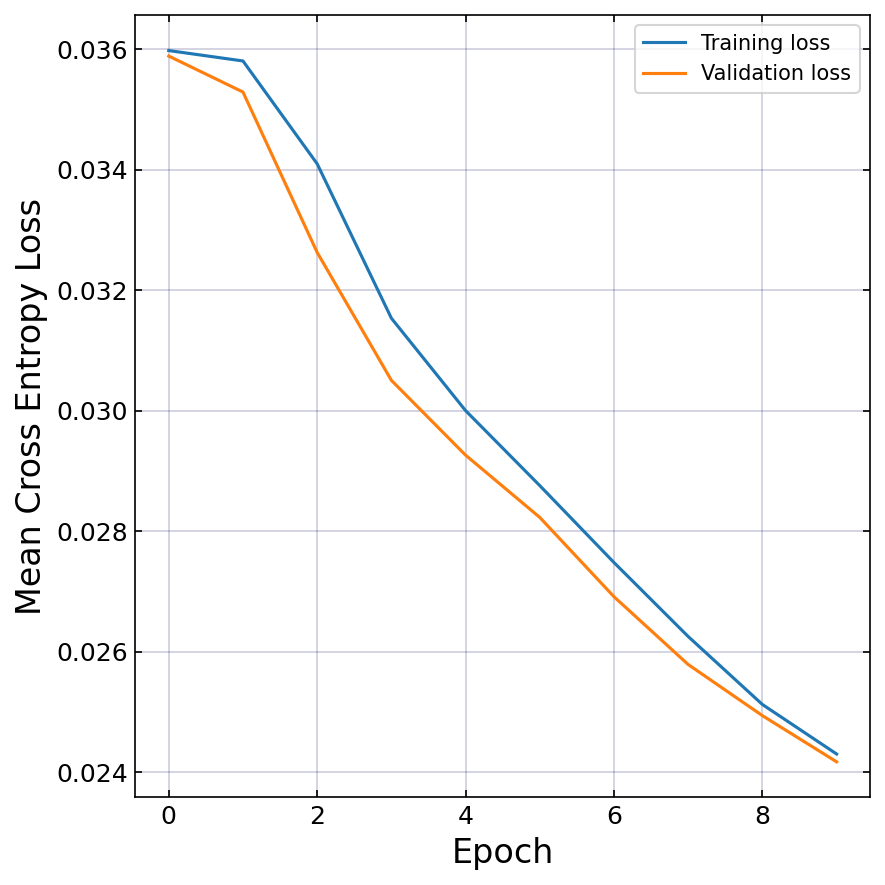

In [54]:
# Plot performance plots

fig, ax = plt.subplots(1,1, figsize = (6, 6), dpi = 150)

ax.plot(train_losses_ex5, label='Training loss')
ax.plot(val_losses_ex5, label='Validation loss')
ax.set_xlabel('Epoch', fontsize = 16)
ax.set_ylabel('Mean Cross Entropy Loss', fontsize = 16)
ax.legend()
ax.grid(color='xkcd:dark blue',alpha = 0.2)
ax.tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)

fig.tight_layout()


Text(0.5, 1.0, 'Confusion matrix for model with AvgPooling')

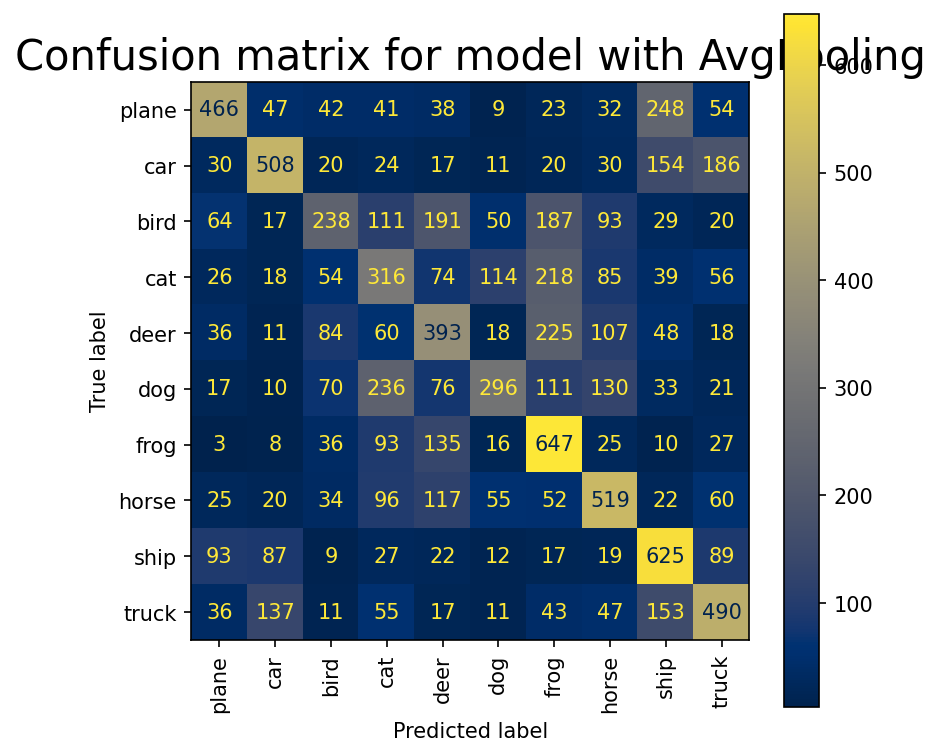

In [55]:
# Plot confusion matrix

fig, ax = plt.subplots(1,1, figsize = (6,6), dpi = 150)

cm = confusion_matrix(y_test_ex5, pred_labels_ex5)
ConfusionMatrixDisplay(cm, display_labels = classes).plot(cmap = plt.cm.cividis, ax = ax, xticks_rotation='vertical')
plt.title('Confusion matrix for model with AvgPooling', fontsize = 20)


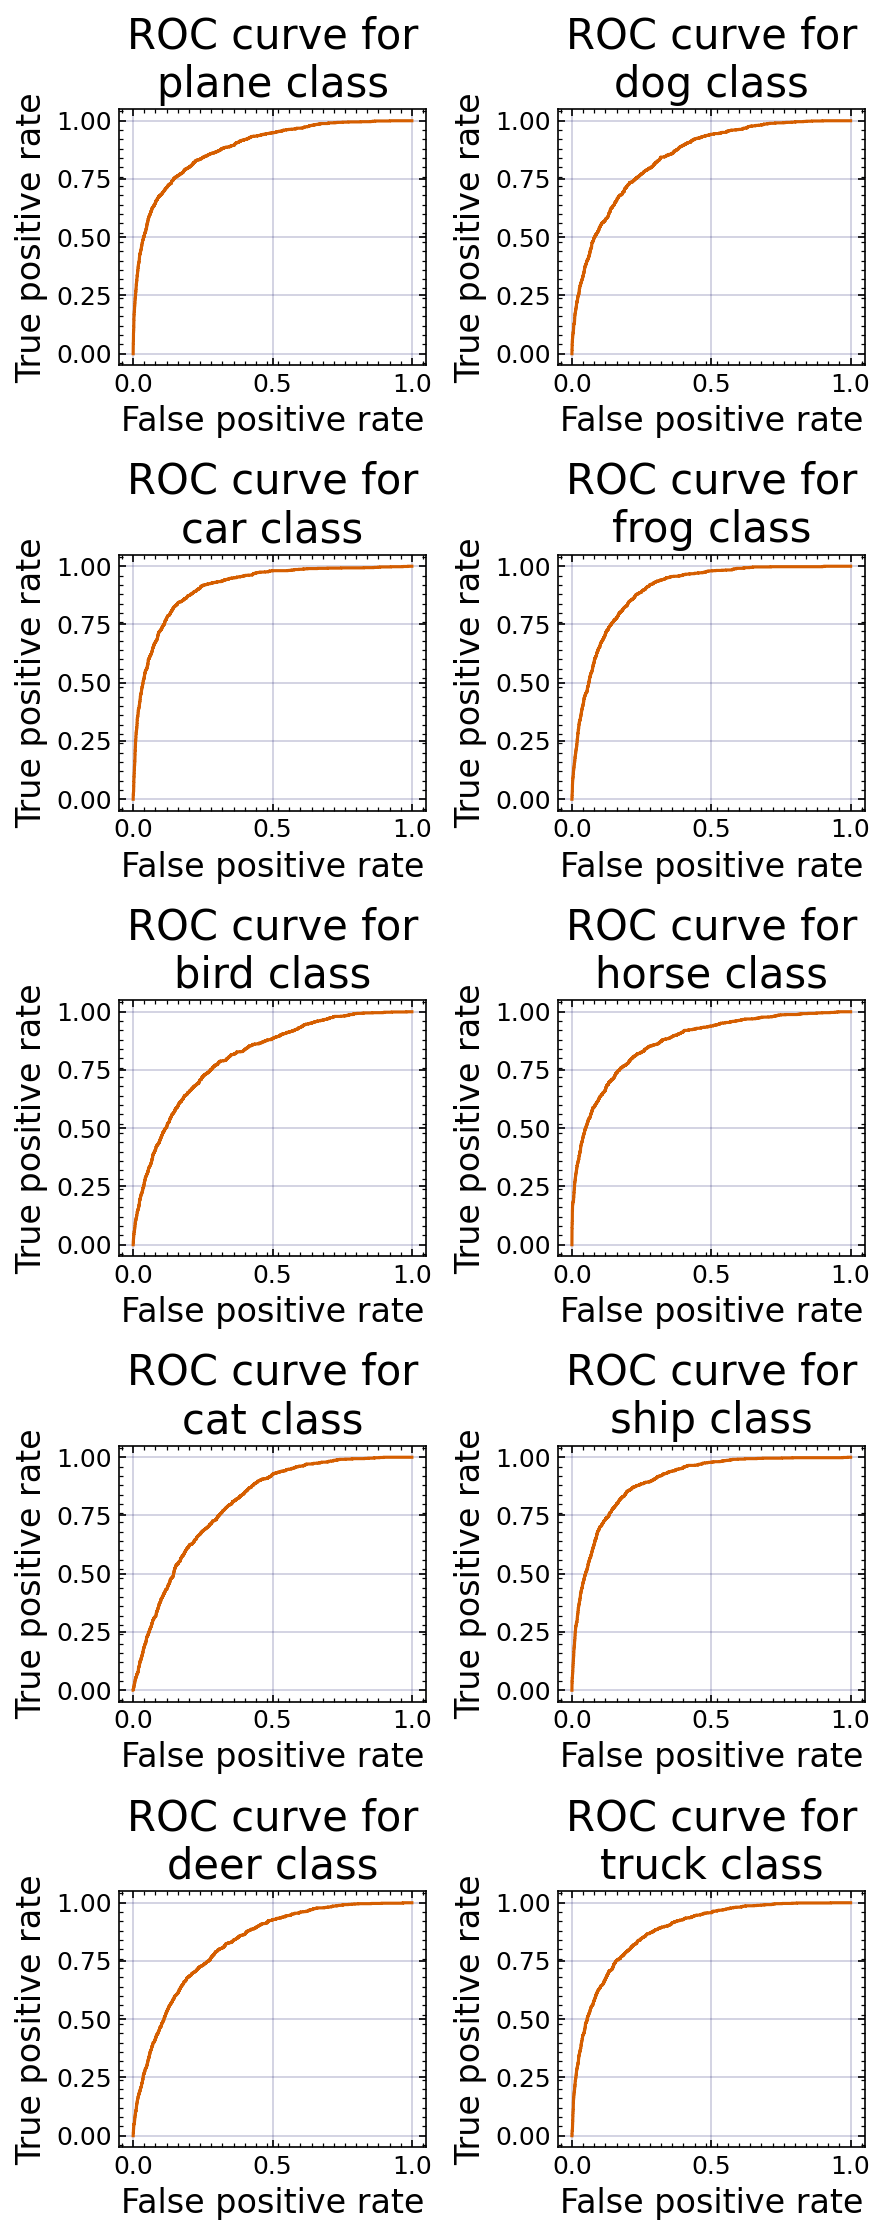

In [57]:
# Plot ROC curves
fig, ax = plt.subplots(5, 2, figsize = (6, 15), dpi = 150)

for i in range(2):
    for j in range(5):
        # Find probability of predicting specific class
        specific_prob = probs_ex5.detach().numpy()[:,j + 5*i]
        # pos_label argument lets us specify the "positive" class
        fpr, tpr, _ = roc_curve(y_test_ex5.detach().numpy(), specific_prob, pos_label = j + 5*i)
        ax[j,i].plot(fpr, tpr, color='#D55E00')
        ax[j,i].set_xlabel('False positive rate',fontsize = 16)
        ax[j,i].set_ylabel('True positive rate', fontsize = 16)
        ax[j,i].xaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].yaxis.set_minor_locator(MultipleLocator(0.04))
        ax[j,i].tick_params(labelsize = 12, which='both',direction='in', top=True, right=True)
        ax[j,i].set_title('ROC curve for\n{} class'.format(classes[j+5*i]), fontsize = 20)
        ax[j,i].grid(color='xkcd:dark blue',alpha = 0.2)

fig.tight_layout()

Your answer here

<div style="background-color:#C2F5DD">

## Exercise 6
    
Finally, try varying any parameters of the network that you like, such as the number of channels in your convolutional layers, any padding, stride, max or average pooling, etc. Remember the following steps:
    
* Define your model, loss function and optimizer (fix seed to keep model parameters the same)
* Define your training loop
* Train for 10 epochs
* Calculate classification accuracy for all data and for each class, and calculate the ROC-AUC score for each class
* Plot the training and validation loss, confusion matrix, and ROC curves for each class

Make sure you save your best performing model with `torch.save`. See the [documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html) for details.
    
    


In [ ]:
# Define model


# Define loss function and optimizer

In [ ]:
# Define training loop

In [ ]:
# Train for 10 epochs


In [ ]:
# Calculate performance metrics


In [ ]:
# Plot performance plots


In [ ]:
# Save best performing model


<div style="background-color:#C2F5DD">

What model architecture performed best? Record your answers in the Markdown cell below.

Your answer here